In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control
from numpy import sin, cos, tan, pi
from control import TransferFunction as TF

In [2]:
import txt_mixin

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
import py_block_diagram

In [5]:
import importlib

In [6]:
import py_block_diagram as pybd

In [6]:
importlib.reload(py_block_diagram)

<module 'py_block_diagram' from '/Users/kraussry/git/py_block_diagram/py_block_diagram/__init__.py'>

In [7]:
import py_block_diagram as pybd

## System Description

In [8]:
mysys = pybd.block_diagram()

In [9]:
N = 500
mysys.N = N

In [10]:
mysys.N

500

In [11]:
U_line_center = pybd.int_constant_block(value=3500)

In [12]:
U_line_center.place_absolute(0,0)

In [13]:
mysys.append_block_to_dict("U_line_center",U_line_center)

In [14]:
U_line_center.variable_name

'U_line_center'

In [15]:
sum1 = pybd.summing_junction()

In [16]:
sum1.set_input_block1(U_line_center)

In [17]:
sum1.place_relative(U_line_center, "right")

In [18]:
mysys.append_block_to_dict("sum1", sum1)

In [19]:
sum1.variable_name

'sum1_block'

In [20]:
D = pybd.P_controller(0.1)

In [21]:
D.Kp

0.1

In [22]:
mysys.append_block_to_dict("D",D)

In [23]:
D.variable_name

'P_block'

In [24]:
D.place_relative(sum1, "right")

In [25]:
D.set_input_block1(sum1)

In [26]:
sat1 = pybd.saturation_block(mymax=200)

In [27]:
sat1.set_input_block1(D)

In [28]:
sat1.place_relative(D, "right")

In [29]:
mysys.append_block_to_dict("sat1",sat1)

In [30]:
line_sense = pybd.i2c_sensor(variable_name="line_sense")

In [31]:
encoder = pybd.i2c_sensor(variable_name="encoder")

In [32]:
mysys.append_sensor(line_sense)

In [33]:
mysys.append_sensor(encoder)

In [34]:
mysys.actuator_name_list

[]

In [35]:
mega_address = 0x07
uno_address = 0x08

In [36]:
G = pybd.cart_pendulum_upy(line_sense,encoder,send_address=mega_address, \
                           read_address1=mega_address, \
                           read_address2=uno_address, i2c=None)

In [37]:
mysys.append_block_to_dict("G",G)

In [38]:
mysys.sensor_name_list

['line_sense', 'encoder']

In [39]:
add1 = pybd.addition_block()

In [40]:
subtract1 = pybd.subtraction_block()

In [41]:
v_nom = pybd.int_constant_block(200,'v_nom_block')

In [42]:
v_nom.place_relative(D, "right", yshift=4, xshift=-4)

In [43]:
mysys.append_block_to_dict("v_nom",v_nom)

In [44]:
add1.place_relative(sat1, "right", yshift=1, xshift=3)

In [45]:
subtract1.place_relative(sat1, "right", yshift=-2)

In [46]:
mysys.append_block_to_dict("add1",add1)

In [47]:
mysys.append_block_to_dict("sub1",subtract1)

In [48]:
add1.set_inputs(v_nom, sat1)

In [49]:
subtract1.set_inputs(v_nom, sat1)

In [50]:
satP = pybd.saturation_block(mymax=400, variable_name="satP")

In [51]:
satN = pybd.saturation_block(mymax=400, variable_name="satN")

In [52]:
satP.set_input_block1(add1)

In [53]:
satP.place_relative(add1, "right")

In [54]:
satN.set_input_block1(subtract1)

In [55]:
satN.place_relative(subtract1, "right")

In [56]:
mysys.append_block_to_dict("satP", satP)

In [57]:
mysys.append_block_to_dict("satN", satN)

In [58]:
G.place_relative(sat1, "right", rel_distance=16)

In [59]:
G.label

'G'

In [60]:
def mydraw2():
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    mysys.ax = ax
    mysys.draw()

drawing: U_line_center
drawing: sum1_block
drawing: P_block
drawing: sat_block
drawing: G
drawing: v_nom_block
drawing: add_block1
drawing: subtract_block1
drawing: satP
drawing: satN


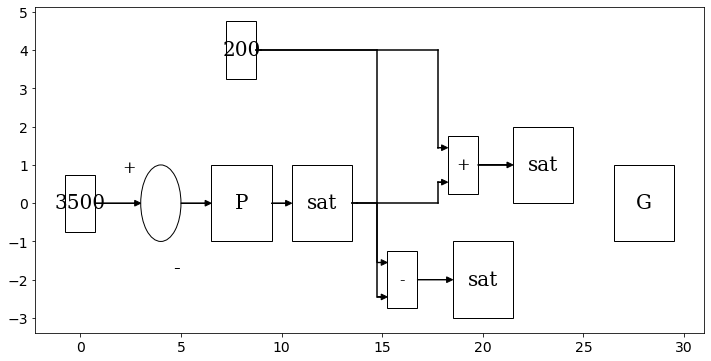

In [61]:
mydraw2()

In [62]:
G.set_inputs(satP,satN)

drawing: U_line_center
drawing: sum1_block
drawing: P_block
drawing: sat_block
drawing: G
drawing: v_nom_block
drawing: add_block1
drawing: subtract_block1
drawing: satP
drawing: satN


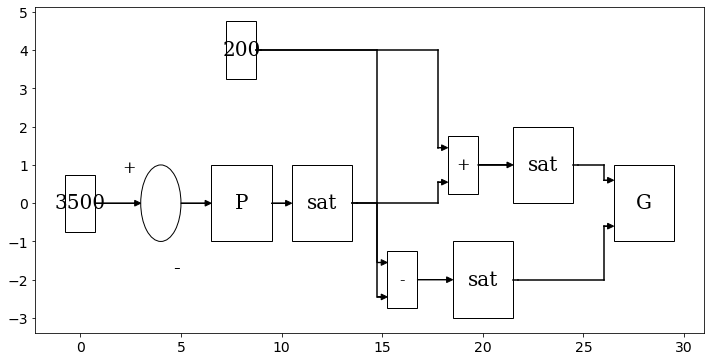

In [63]:
mydraw2()

In [64]:
Y = pybd.output_block("line position",line_sense)

In [65]:
Y.place_relative(line_sense, "right",8)

In [66]:
Y.width = 6

In [67]:
mysys.append_block_to_dict("Y",Y)

drawing: U_line_center
drawing: sum1_block
drawing: P_block
drawing: sat_block
drawing: G
drawing: v_nom_block
drawing: add_block1
drawing: subtract_block1
drawing: satP
drawing: satN
drawing: Y


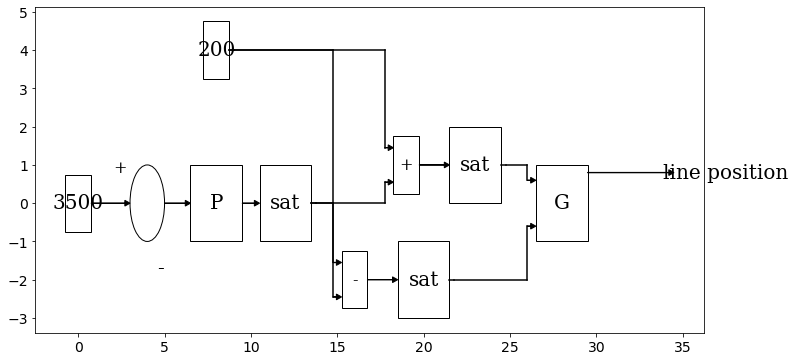

In [68]:
mydraw2()

In [69]:
sum1.set_input_block2(line_sense)

drawing: U_line_center
drawing: sum1_block
calling draw_feedback_wire
drawing: P_block
drawing: sat_block
drawing: G
drawing: v_nom_block
drawing: add_block1
drawing: subtract_block1
drawing: satP
drawing: satN
drawing: Y


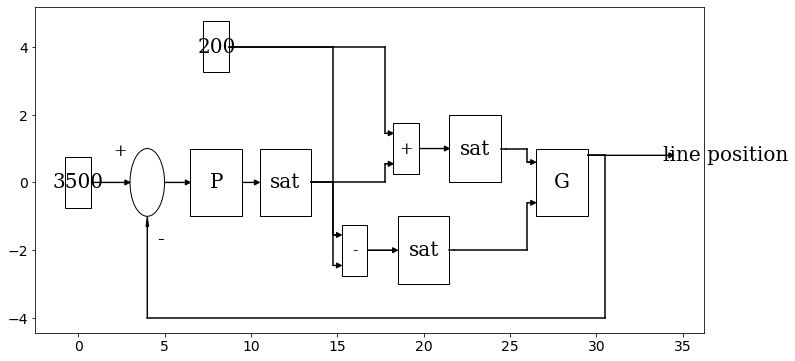

In [70]:
mydraw2()

In [71]:
D.py_params

['Kp']

## Print Blocks

In [72]:
mysys.print_blocks = [U_line_center,D,sat1,satP,satN,line_sense]

## Execution Order

In [73]:
mysys.find_execution_order([G,U_line_center,sum1,D,sat1,v_nom,add1,subtract1,satP,satN])

In [74]:
mysys.execution_order

## Codegen Test

In [75]:
ls *.py

main.py*                              main_template.py*
main_backup_hbridge_motor_control.py* upybd.py


In [76]:
folder = "cart_pend_P_control"

In [77]:
import rwkos

In [78]:
rwkos.make_dir(folder)

In [79]:
mysys.generate_python_code("main.py", \
                           "main_template.py", \
                            output_folder=folder, N=N)

In [80]:
add1.input_block1_name

'v_nom_block'

In [81]:
add1.get_python_secondary_init_code()

['add_block1.set_input_block1(v_nom_block)',
 'add_block1.set_input_block2(sat_block)',
 'add_block1.init_vectors(N)']

In [82]:
mysys.print_blocks

In [83]:
import shutil, os

In [84]:
src_path = os.path.join(folder, "main.py")
src_path

'cart_pend_P_control/main.py'

In [85]:
dst_path = "main.py"

In [86]:
shutil.copyfile(src_path,dst_path)

'main.py'

In [87]:
G.x

28

In [88]:
G.y

0

In [89]:
line_sense.x

29.5

In [90]:
line_sense.y

0.8

In [7]:
pybd.actuator_class_names

['h_bridge', 'custom_actuator', 'pwm_output']

In [8]:
pybd.plant_class_names

['plant',
 'plant_no_actuator',
 'plant_with_double_actuator',
 'plant_with_double_actuator_two_sensors',
 'plant_with_two_i2c_inputs_and_two_i2c_sensors',
 'cart_pendulum_upy']

In [9]:
1 % 2

1

In [10]:
2 % 2

0

In [11]:
3 % 2

1

In [12]:
4 % 2

0

In [13]:
isodd(3)

NameError: name 'isodd' is not defined

In [14]:
"%0.4g" % 3

'3'